<a href="https://colab.research.google.com/github/jkim2260/CoworkPractice/blob/master/Finish_Set_DeepLearning_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 입력데이터_정규화(X,y) 확인, 테스트시 model_eval() 및 Test 코드 추가해서 다시 확인
# Bayesian Optimization 다방면으로 더확인_

In [ ]:
#Pytorch library 불러오기
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
#파일 직접 업로드하기
from google.colab import files
myfile = files.upload()

TypeError: ignored

In [ ]:
#데이터 불러오기

df = pd.read_csv('R5_test.csv')
df.head()

,Od_Temp,Od_Hum,CTW_Stemp,CTW_Flow,kWh
0,25.9,69.9,29.9,107.0,182.1
1,25.8,68.7,25.8,108.4,155.8
2,25.6,70.7,26.0,108.6,198.5
3,25.3,73.2,26.2,163.4,154.1
4,25.2,76.7,26.3,176.6,265.7


In [ ]:
# 데이터의 수치통계
df.describe()

,Od_Temp,Od_Hum,CTW_Stemp,CTW_Flow,kWh
count,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000
mean,29.348589,69.114449,30.719556,220.111358,527.629032
std,2.993469,11.616592,2.075667,133.088894,386.895088
min,22.000000,53.600000,22.100000,42.100000,-135.500000
25%,27.400000,59.175000,30.000000,109.775000,175.000000
50%,29.400000,65.600000,31.700000,182.850000,477.850000
75%,31.300000,78.925000,32.000000,314.175000,834.300000
max,37.600000,96.400000,36.500000,620.600000,1718.300000


In [ ]:
#데이터 정보 및 데이터타입 확인
df.info()
#누락된 데이터 값 확인
df.isnull().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Od_Temp    1488 non-null   float64
 1   Od_Hum     1488 non-null   float64
 2   CTW_Stemp  1488 non-null   float64
 3   CTW_Flow   1488 non-null   float64
 4   kWh        1488 non-null   float64
dtypes: float64(5)
memory usage: 58.2 KB


0

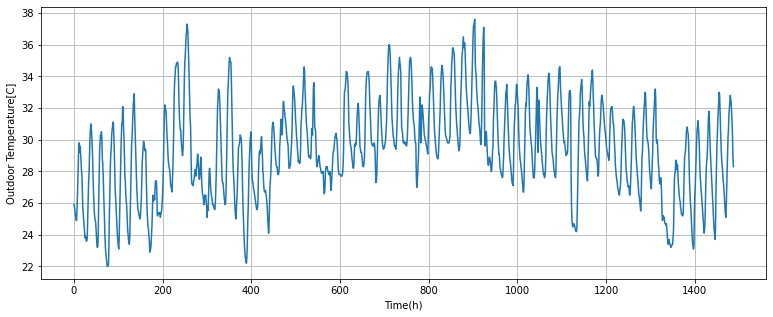

In [ ]:
df['Od_Temp'].plot(grid=True, figsize=(13,5));
plt.xlabel('Time(h)')
plt.ylabel('Outdoor Temperature[C]')
plt.show()

In [ ]:
# pandas data를 입력변수 X, 출력변수 y로 나누어줌
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3 , random_state=2)

# Train data
print("X_train size:" , X_train.shape)
print("y_train size:" , y_train.shape, '\n')

# Test data
print("X_test size:", X_test.shape)
print("y_test size:", y_test.shape)
print(type(y_train))


#data type을 series에서 dataframe으로 변경(데이터 정규화하기 위해서)
y_train = y_train.to_frame()
print(type(y_train_ss))
y_test = y_test.to_frame()
print(type(y_test_ss))

NameError: ignored

In [ ]:
# training data Scaling
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

y_train_ss = ss.fit_transform(y_train_ss)
y_test_ss = ss.fit_transform(y_test_ss)

#scaler.fit(X_train)
#X_train_scale = scaler.transform(X_train) #x_train scale is numpy ndarray

# test data Scaling
#X_test_scale = scaler.transform(X_test) #x_test_scale is numpy ndarray

#-------numpy data --> Tensor ------------

# Array --> Tensor
X_train_tensor = torch.FloatTensor(X_train_ss)
y_train_tensor = torch.FloatTensor(y_train_ss)#.values) #y_train is pandas series using values numpy ndarray

X_test_tensor = torch.FloatTensor(X_test_ss)
y_test_tensor = torch.FloatTensor(y_test_ss) #.values)

In [ ]:
#Training data batch learning(배치넣을려고 들고오는 것)
train_data = data_utils.TensorDataset(X_train_tensor, y_train_tensor)

dataloader = data_utils.DataLoader(train_data, batch_size = 100, shuffle = False) #시계열 데이터는 shuffle=False #drop_last= True???

#Batch size check
for batch_idx, datas in enumerate(dataloader):
    print(batch_idx)
    print(datas[0].shape) #x_train
    print(datas[1].shape) #y_train
    break

0
torch.Size([100, 4])
torch.Size([100, 1])


Case 1_Optimizer SGD

In [ ]:
#일반 모델 구축
#Modeling
class MLP_model(torch.nn.Module):
        def __init__(self, input_size, hidden_size, hidden_1_size, output_size):
            super(MLP_model, self).__init__() #super class name
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.hidden_1_size = hidden_1_size
            self.output_size = output_size

            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_1_size)
            self.fc3 = torch.nn.Linear(self.hidden_1_size, self.output_size)
            self.relu = torch.nn.ReLU()
            self.sig = torch.nn.Sigmoid()

        def forward(self, x):
            fc1 = self.fc1(x)
            ac1 = self.relu(fc1)

            fc2 = self.fc2(ac1)
            ac2 = self.relu(fc2)

            fc3 = self.fc3(ac2)

            return fc3


#hidden_1_size add

In [ ]:
#HyperParameter definition
input_dim = 4 #independent variable x
output_dim = 1 #output y
hidden_dim = 32 #(32,64,128,256)
hidden_1_dim = 16
learning_rate = 0.0001
n_epochs =1000
# hidden, epoch number reduction overfitting limitation.

In [ ]:
#model creation
model = MLP_model(input_size = input_dim, hidden_size=hidden_dim, hidden_1_size=hidden_1_dim, output_size = output_dim)
#loss function
criterion = torch.nn.MSELoss()
#Optimizer(ADAM_TRAINING_MANY OF TYPES)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Training

In [ ]:
#Training Model
train_loss = [] #empty list add
test_loss =[]   #empty list add

for epoch in range(n_epochs+1):

    #Batch learning
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        optimizer.zero_grad() #gradient value reset
        y_pred = model(x_batch)
        y_pred = y_pred.reshape(-1) #dimension reduction 100,1(y_pred) --> loss function same demension y_batch(100,) 
        loss_train = criterion(y_pred, y_batch) #same dimension
        loss_train.backward() #gradient value calcaulation
        optimizer.step() #weight value update

    #Validation #train, test comparison
        y_test_pred = model(X_test_tensor)
        y_test_pred = y_test_pred.reshape(-1)
        loss_test = criterion(y_test_pred, y_test_tensor)
 
    train_loss.append(loss_train.item())
    test_loss.append(loss_test.item())
    print("epoch:{}, Loss_train:{:.2f}, Loss_test:{:.2f}".format(epoch, train_loss[-1], test_loss[-1]))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([447, 1])) that is different to the input size (torch.Size([447])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([41, 1])) that is different to the input size (torch.Size([41])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

epoch:0, Loss_train:1.15, Loss_test:1.05
epoch:1, Loss_train:1.15, Loss_test:1.05
epoch:2, Loss_train:1.15, Loss_test:1.05
epoch:3, Loss_train:1.15, Loss_test:1.05
epoch:4, Loss_train:1.15, Loss_test:1.05
epoch:5, Loss_train:1.15, Loss_test:1.05
epoch:6, Loss_train:1.15, Loss_test:1.04
epoch:7, Loss_train:1.15, Loss_test:1.04
epoch:8, Loss_train:1.15, Loss_test:1.04
epoch:9, Loss_train:1.15, Loss_test:1.04
epoch:10, Loss_train:1.14, Loss_test:1.04
epoch:11, Loss_train:1.14, Loss_test:1.04
epoch:12, Loss_train:1.14, Loss_test:1.04
epoch:13, Loss_train:1.14, Loss_test:1.04
epoch:14, Loss_train:1.14, Loss_test:1.04
epoch:15, Loss_train:1.14, Loss_test:1.04
epoch:16, Loss_train:1.14, Loss_test:1.04
epoch:17, Loss_train:1.14, Loss_test:1.04
epoch:18, Loss_train:1.14, Loss_test:1.04
epoch:19, Loss_train:1.14, Loss_test:1.04
epoch:20, Loss_train:1.14, Loss_test:1.04
epoch:21, Loss_train:1.14, Loss_test:1.04
epoch:22, Loss_train:1.14, Loss_test:1.04
epoch:23, Loss_train:1.14, Loss_test:1.04
ep

<function matplotlib.pyplot.show>

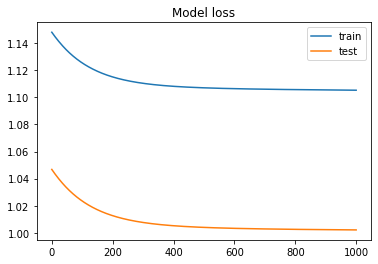

In [ ]:
#Loss value plot
plt.figure()
plt.plot(train_loss, label='train')
plt.plot(test_loss, label = 'test')
plt.title('Model loss')
plt.legend(loc='upper right')
plt.show

#sharp graph batch size --> full batch learning soft graph

In [ ]:
import pickle

# wb- 바이트 형식으로 저장

with open('SGD.pickle', 'wb') as f:
     pickle.dump(test_loss, f)

Case 2_Optimizer ADAM

In [ ]:
#데이터 불러오기

df = pd.read_csv('R5_test.csv')
df.head()

,Od_Temp,Od_Hum,CTW_Stemp,CTW_Flow,kWh
0,25.9,69.9,29.9,107.0,182.1
1,25.8,68.7,25.8,108.4,155.8
2,25.6,70.7,26.0,108.6,198.5
3,25.3,73.2,26.2,163.4,154.1
4,25.2,76.7,26.3,176.6,265.7


In [ ]:
# pandas data를 입력변수 X, 출력변수 y로 나누어줌
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3 , random_state=2)

# Train data
print("X_train size:" , X_train.shape)
print("y_train size:" , y_train.shape, '\n')

# Test data
print("X_test size:", X_test.shape)
print("y_test size:", y_test.shape)
print(type(y_train))

X_train size: (1041, 4)
y_train size: (1041,) 

X_test size: (447, 4)
y_test size: (447,)
<class 'pandas.core.series.Series'>


In [ ]:
# training data Scaling
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

y_train_ss = ss.fit_transform(y_train_ss)
y_test_ss = ss.fit_transform(y_test_ss)

# Array --> Tensor
X_train_tensor = torch.FloatTensor(X_train_ss)
y_train_tensor = torch.FloatTensor(y_train_ss)#.values) #y_train is pandas series using values numpy ndarray

X_test_tensor = torch.FloatTensor(X_test_ss)
y_test_tensor = torch.FloatTensor(y_test_ss) #.values)

In [ ]:
#Training data batch learning
train_data = data_utils.TensorDataset(X_train_tensor, y_train_tensor)

dataloader = data_utils.DataLoader(train_data, batch_size = 100, shuffle = False) # drop_last= True??

#Batch size check
for batch_idx, datas in enumerate(dataloader):
    print(batch_idx)
    print(datas[0].shape) #x_train
    print(datas[1].shape) #y_train
    break

0
torch.Size([100, 4])
torch.Size([100, 1])


In [ ]:
#일반 모델 구축
#Modeling
class MLP_model(torch.nn.Module):
        def __init__(self, input_size, hidden_size, hidden_1_size, output_size):
            super(MLP_model, self).__init__() #super class name
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.hidden_1_size = hidden_1_size
            self.output_size = output_size

            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_1_size)
            self.fc3 = torch.nn.Linear(self.hidden_1_size, self.output_size)
            self.relu = torch.nn.ReLU()
            self.sig = torch.nn.Sigmoid()

        def forward(self, x):
            fc1 = self.fc1(x)
            ac1 = self.relu(fc1)

            fc2 = self.fc2(ac1)
            ac2 = self.relu(fc2)

            fc3 = self.fc3(ac2)

            return fc3


#hidden_1_size add

In [ ]:
#HyperParameter definition
input_dim = 4 #independent variable x
output_dim = 1 #output y
hidden_dim = 32 #(32,64,128,256)
hidden_1_dim = 16
learning_rate = 0.0001
n_epochs =1000
# hidden, epoch number reduction overfitting limitation.

In [ ]:
#model creation
model = MLP_model(input_size = input_dim, hidden_size=hidden_dim, hidden_1_size=hidden_1_dim, output_size = output_dim)
#loss function
criterion = torch.nn.MSELoss()
#Optimizer(ADAM_TRAINING_MANY OF TYPES)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#Training Model
train_loss = [] #empty list add
test_loss =[]   #empty list add

for epoch in range(n_epochs+1):

    #Batch learning
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        optimizer.zero_grad() #gradient value reset
        y_pred = model(x_batch)
        y_pred = y_pred.reshape(-1) #dimension reduction 100,1(y_pred) --> loss function same demension y_batch(100,) 
        loss_train = criterion(y_pred, y_batch) #same dimension
        loss_train.backward() #gradient value calcaulation
        optimizer.step() #weight value update

    #Validation #train, test comparison
        y_test_pred = model(X_test_tensor)
        y_test_pred = y_test_pred.reshape(-1)
        loss_test = criterion(y_test_pred, y_test_tensor)
 
    train_loss.append(loss_train.item())
    test_loss.append(loss_test.item())
    print("epoch:{}, Loss_train:{:.2f}, Loss_test:{:.2f}".format(epoch, train_loss[-1], test_loss[-1]))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([447, 1])) that is different to the input size (torch.Size([447])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([41, 1])) that is different to the input size (torch.Size([41])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

epoch:0, Loss_train:1.23, Loss_test:1.14
epoch:1, Loss_train:1.22, Loss_test:1.13
epoch:2, Loss_train:1.21, Loss_test:1.12
epoch:3, Loss_train:1.20, Loss_test:1.11
epoch:4, Loss_train:1.20, Loss_test:1.10
epoch:5, Loss_train:1.19, Loss_test:1.10
epoch:6, Loss_train:1.18, Loss_test:1.09
epoch:7, Loss_train:1.17, Loss_test:1.08
epoch:8, Loss_train:1.17, Loss_test:1.08
epoch:9, Loss_train:1.16, Loss_test:1.07
epoch:10, Loss_train:1.15, Loss_test:1.06
epoch:11, Loss_train:1.15, Loss_test:1.06
epoch:12, Loss_train:1.14, Loss_test:1.05
epoch:13, Loss_train:1.14, Loss_test:1.05
epoch:14, Loss_train:1.14, Loss_test:1.04
epoch:15, Loss_train:1.13, Loss_test:1.04
epoch:16, Loss_train:1.13, Loss_test:1.03
epoch:17, Loss_train:1.13, Loss_test:1.03
epoch:18, Loss_train:1.12, Loss_test:1.03
epoch:19, Loss_train:1.12, Loss_test:1.02
epoch:20, Loss_train:1.12, Loss_test:1.02
epoch:21, Loss_train:1.12, Loss_test:1.02
epoch:22, Loss_train:1.12, Loss_test:1.02
epoch:23, Loss_train:1.11, Loss_test:1.02
ep

<function matplotlib.pyplot.show>

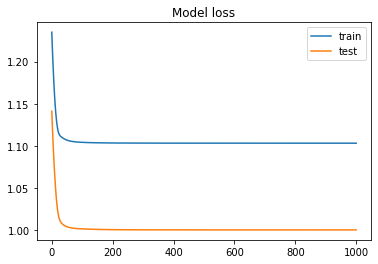

In [ ]:
#Loss value plot
plt.figure()
plt.plot(train_loss, label='train')
plt.plot(test_loss, label = 'test')
plt.title('Model loss')
plt.legend(loc='upper right')
plt.show

#sharp graph batch size --> full batch learning soft graph

In [ ]:
import pickle

# wb- 바이트 형식으로 저장

with open('Adam.pickle', 'wb') as f:
     pickle.dump(test_loss, f)

Case3_Drop Out

In [ ]:
#데이터 불러오기

df = pd.read_csv('R5_test.csv')
df.head()

,Od_Temp,Od_Hum,CTW_Stemp,CTW_Flow,kWh
0,25.9,69.9,29.9,107.0,182.1
1,25.8,68.7,25.8,108.4,155.8
2,25.6,70.7,26.0,108.6,198.5
3,25.3,73.2,26.2,163.4,154.1
4,25.2,76.7,26.3,176.6,265.7


In [ ]:
# pandas data를 입력변수 X, 출력변수 y로 나누어줌
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3 , random_state=2)

# Train data
print("X_train size:" , X_train.shape)
print("y_train size:" , y_train.shape, '\n')

# Test data
print("X_test size:", X_test.shape)
print("y_test size:", y_test.shape)
print(type(y_train))

X_train size: (1041, 4)
y_train size: (1041,) 

X_test size: (447, 4)
y_test size: (447,)
<class 'pandas.core.series.Series'>


In [ ]:
# training data Scaling
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

y_train_ss = ss.fit_transform(y_train_ss)
y_test_ss = ss.fit_transform(y_test_ss)

# Array --> Tensor
X_train_tensor = torch.FloatTensor(X_train_ss)
y_train_tensor = torch.FloatTensor(y_train_ss)#.values) #y_train is pandas series using values numpy ndarray

X_test_tensor = torch.FloatTensor(X_test_ss)
y_test_tensor = torch.FloatTensor(y_test_ss) #.values)

In [ ]:
#Training data batch learning
train_data = data_utils.TensorDataset(X_train_tensor, y_train_tensor)

dataloader = data_utils.DataLoader(train_data, batch_size = 100, shuffle = False) #drop_last= True)?

#Batch size check
for batch_idx, datas in enumerate(dataloader):
    print(batch_idx)
    print(datas[0].shape) #x_train
    print(datas[1].shape) #y_train
    break

0
torch.Size([100, 4])
torch.Size([100, 1])


In [ ]:
# p - probablity of an elment to be zeroed. Default:0.5 --> 0
drop_prob1 = 0.4 #40% out
drop_prob2 = 0.24 #25% out


#Modeling
class MLP_model(torch.nn.Module):
        def __init__(self, input_size, hidden_size, hidden_1_size, output_size):
            super(MLP_model, self).__init__() #super class name
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.hidden_1_size = hidden_1_size
            self.output_size = output_size

            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_1_size)
            self.fc3 = torch.nn.Linear(self.hidden_1_size, self.output_size)
            self.relu = torch.nn.ReLU()
            self.sig = torch.nn.Sigmoid()

            self.dp1 = nn.Dropout(p=drop_prob1)
            self.dp2 = nn.Dropout(p=drop_prob2)

        def forward(self, x):
            fc1 = self.fc1(x)
            ac1 = self.relu(fc1)
            h1dp = self.dp1(ac1)

            fc2 = self.fc2(ac1)
            ac2 = self.relu(fc2)
            h2dp = self.dp2(ac2)

            fc3 = self.fc3(ac2)

            return fc3


In [ ]:
#HyperParameter definition
input_dim = 4 #independent variable x
output_dim = 1 #output y
hidden_dim = 32 #(32,64,128,256)
hidden_1_dim = 16
learning_rate = 0.0001
n_epochs =1000
# hidden, epoch number reduction overfitting limitation.

In [ ]:
#model creation
model = MLP_model(input_size = input_dim, hidden_size=hidden_dim, hidden_1_size=hidden_1_dim, output_size = output_dim)
#loss function
criterion = torch.nn.MSELoss()
#Optimizer(ADAM_TRAINING_MANY OF TYPES)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#Training Model
train_loss = [] #empty list add
test_loss =[]   #empty list add

for epoch in range(n_epochs+1):

    #Batch learning
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        optimizer.zero_grad() #gradient value reset
        y_pred = model(x_batch)
        y_pred = y_pred.reshape(-1) #dimension reduction 100,1(y_pred) --> loss function same demension y_batch(100,) 
        loss_train = criterion(y_pred, y_batch) #same dimension
        loss_train.backward() #gradient value calcaulation
        optimizer.step() #weight value update

    #Validation #train, test comparison
        model.eval()
        y_test_pred = model(X_test_tensor)
        y_test_pred = y_test_pred.reshape(-1)
        loss_test = criterion(y_test_pred, y_test_tensor)
 
    train_loss.append(loss_train.item())
    test_loss.append(loss_test.item())
    print("epoch:{}, Loss_train:{:.2f}, Loss_test:{:.2f}".format(epoch, train_loss[-1], test_loss[-1]))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([447, 1])) that is different to the input size (torch.Size([447])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([41, 1])) that is different to the input size (torch.Size([41])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

epoch:0, Loss_train:1.11, Loss_test:1.01
epoch:1, Loss_train:1.11, Loss_test:1.01
epoch:2, Loss_train:1.11, Loss_test:1.01
epoch:3, Loss_train:1.11, Loss_test:1.01
epoch:4, Loss_train:1.11, Loss_test:1.00
epoch:5, Loss_train:1.11, Loss_test:1.00
epoch:6, Loss_train:1.11, Loss_test:1.00
epoch:7, Loss_train:1.11, Loss_test:1.00
epoch:8, Loss_train:1.10, Loss_test:1.00
epoch:9, Loss_train:1.10, Loss_test:1.00
epoch:10, Loss_train:1.10, Loss_test:1.00
epoch:11, Loss_train:1.10, Loss_test:1.00
epoch:12, Loss_train:1.10, Loss_test:1.00
epoch:13, Loss_train:1.10, Loss_test:1.00
epoch:14, Loss_train:1.10, Loss_test:1.00
epoch:15, Loss_train:1.10, Loss_test:1.00
epoch:16, Loss_train:1.10, Loss_test:1.00
epoch:17, Loss_train:1.10, Loss_test:1.00
epoch:18, Loss_train:1.10, Loss_test:1.00
epoch:19, Loss_train:1.10, Loss_test:1.00
epoch:20, Loss_train:1.10, Loss_test:1.00
epoch:21, Loss_train:1.10, Loss_test:1.00
epoch:22, Loss_train:1.10, Loss_test:1.00
epoch:23, Loss_train:1.10, Loss_test:1.00
ep

<function matplotlib.pyplot.show>

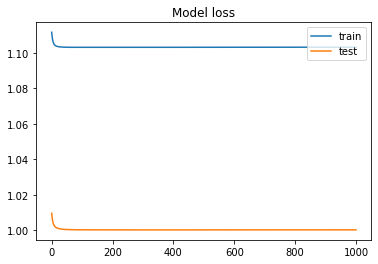

In [ ]:
#Loss value plot
plt.figure()
plt.plot(train_loss, label='train')
plt.plot(test_loss, label = 'test')
plt.title('Model loss')
plt.legend(loc='upper right')
plt.show

#sharp graph batch size --> full batch learning soft graph

In [ ]:
import pickle

# wb- 바이트 형식으로 저장

with open('Dropout.pickle', 'wb') as f:
     pickle.dump(test_loss, f)

Case 4_ Batch Normalization

In [ ]:
#데이터 불러오기

df = pd.read_csv('R5_test.csv')
df.head()

,Od_Temp,Od_Hum,CTW_Stemp,CTW_Flow,kWh
0,25.9,69.9,29.9,107.0,182.1
1,25.8,68.7,25.8,108.4,155.8
2,25.6,70.7,26.0,108.6,198.5
3,25.3,73.2,26.2,163.4,154.1
4,25.2,76.7,26.3,176.6,265.7


In [ ]:
# pandas data를 입력변수 X, 출력변수 y로 나누어줌
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3 , random_state=2)

# Train data
print("X_train size:" , X_train.shape)
print("y_train size:" , y_train.shape, '\n')

# Test data
print("X_test size:", X_test.shape)
print("y_test size:", y_test.shape)
print(type(y_train))

X_train size: (1041, 4)
y_train size: (1041,) 

X_test size: (447, 4)
y_test size: (447,)
<class 'pandas.core.series.Series'>


In [ ]:
# training data Scaling
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

y_train_ss = ss.fit_transform(y_train_ss)
y_test_ss = ss.fit_transform(y_test_ss)

# Array --> Tensor
X_train_tensor = torch.FloatTensor(X_train_ss)
y_train_tensor = torch.FloatTensor(y_train_ss)#.values) #y_train is pandas series using values numpy ndarray

X_test_tensor = torch.FloatTensor(X_test_ss)
y_test_tensor = torch.FloatTensor(y_test_ss) #.values)

In [ ]:
#Training data batch learning
train_data = data_utils.TensorDataset(X_train_tensor, y_train_tensor)

dataloader = data_utils.DataLoader(train_data, batch_size = 100, shuffle = False) #, drop_last= True)

#Batch size check
for batch_idx, datas in enumerate(dataloader):
    print(batch_idx)
    print(datas[0].shape) #x_train
    print(datas[1].shape) #y_train
    break

0
torch.Size([100, 4])
torch.Size([100, 1])


In [ ]:
#HyperParameter definition
input_dim = 4 #independent variable x
output_dim = 1 #output y
hidden_dim = 32 #(32,64,128,256)
hidden_1_dim = 16
learning_rate = 0.0001
n_epochs =1000
# hidden, epoch number reduction overfitting limitation.

#Modeling
class Batch_Norm(nn.Module):
    def __init__(self):
        super(Batch_Norm, self).__init__()
        
        self.network = nn.Sequential(nn.Linear(4, 32),
                                     nn.BatchNorm1d(32),
                                     nn.ReLU(),
                                     nn.Linear(32,16),
                                     nn.BatchNorm1d(16),
                                     nn.ReLU(),
                                     nn.Linear(16,1))

    def forward(self, x):
        output =self.network(x) #input network에 x 입력데이터를 넣는다

        return output

In [ ]:
epoch = 15
learning_rate = 0.01

#model creation
model =Batch_Norm()
#loss function
criterion = torch.nn.MSELoss()
#Optimizer(ADAM_TRAINING_MANY OF TYPES)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#Training Model
train_loss = [] #empty list add
test_loss =[]   #empty list add

for epoch in range(n_epochs+1):

    #Batch learning
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        optimizer.zero_grad() #gradient value reset
        y_pred = model(x_batch)
        y_pred = y_pred.reshape(-1) #dimension reduction 100,1(y_pred) --> loss function same demension y_batch(100,) 
        loss_train = criterion(y_pred, y_batch) #same dimension
        loss_train.backward() #gradient value calcaulation
        optimizer.step() #weight value update

    #Validation #train, test comparison
        y_test_pred = model(X_test_tensor)
        y_test_pred = y_test_pred.reshape(-1)
        loss_test = criterion(y_test_pred, y_test_tensor)
 
    train_loss.append(loss_train.item())
    test_loss.append(loss_test.item())
    print("epoch:{}, Loss_train:{:.2f}, Loss_test:{:.2f}".format(epoch, train_loss[-1], test_loss[-1]))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([447, 1])) that is different to the input size (torch.Size([447])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([41, 1])) that is different to the input size (torch.Size([41])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

epoch:0, Loss_train:1.13, Loss_test:1.02
epoch:1, Loss_train:1.11, Loss_test:1.00
epoch:2, Loss_train:1.10, Loss_test:1.00
epoch:3, Loss_train:1.10, Loss_test:1.00
epoch:4, Loss_train:1.10, Loss_test:1.00
epoch:5, Loss_train:1.10, Loss_test:1.00
epoch:6, Loss_train:1.10, Loss_test:1.00
epoch:7, Loss_train:1.10, Loss_test:1.00
epoch:8, Loss_train:1.10, Loss_test:1.00
epoch:9, Loss_train:1.10, Loss_test:1.00
epoch:10, Loss_train:1.10, Loss_test:1.00
epoch:11, Loss_train:1.10, Loss_test:1.00
epoch:12, Loss_train:1.10, Loss_test:1.00
epoch:13, Loss_train:1.10, Loss_test:1.00
epoch:14, Loss_train:1.10, Loss_test:1.00
epoch:15, Loss_train:1.10, Loss_test:1.00
epoch:16, Loss_train:1.10, Loss_test:1.00
epoch:17, Loss_train:1.10, Loss_test:1.00
epoch:18, Loss_train:1.10, Loss_test:1.00
epoch:19, Loss_train:1.10, Loss_test:1.00
epoch:20, Loss_train:1.10, Loss_test:1.00
epoch:21, Loss_train:1.10, Loss_test:1.00
epoch:22, Loss_train:1.10, Loss_test:1.00
epoch:23, Loss_train:1.10, Loss_test:1.00
ep

<function matplotlib.pyplot.show>

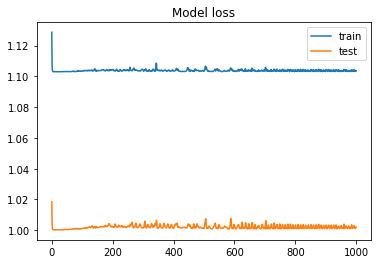

In [ ]:
#Loss value plot
plt.figure()
plt.plot(train_loss, label='train')
plt.plot(test_loss, label = 'test')
plt.title('Model loss')
plt.legend(loc='upper right')
plt.show

#sharp graph batch size --> full batch learning soft graph

In [ ]:
import pickle

# wb- 바이트 형식으로 저장

with open('BatchNorm.pickle', 'wb') as f:
     pickle.dump(test_loss, f)

4가지 Case 비교

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
with open("SGD.pickle", 'rb') as f: #각각 파일마다 피클로 저장해둬야 함
      SGD = pickle.load(f)

In [ ]:
with open("Adam.pickle", 'rb') as f: #각각 파일마다 피클로 저장해둬야 함
      ADAM = pickle.load(f)

In [ ]:
with open("Dropout.pickle", 'rb') as f: #각각 파일마다 피클로 저장해둬야 함
      Dropout = pickle.load(f)

In [ ]:
with open("BatchNorm.pickle", 'rb') as f: #각각 파일마다 피클로 저장해둬야 함
      BatchNorm = pickle.load(f)

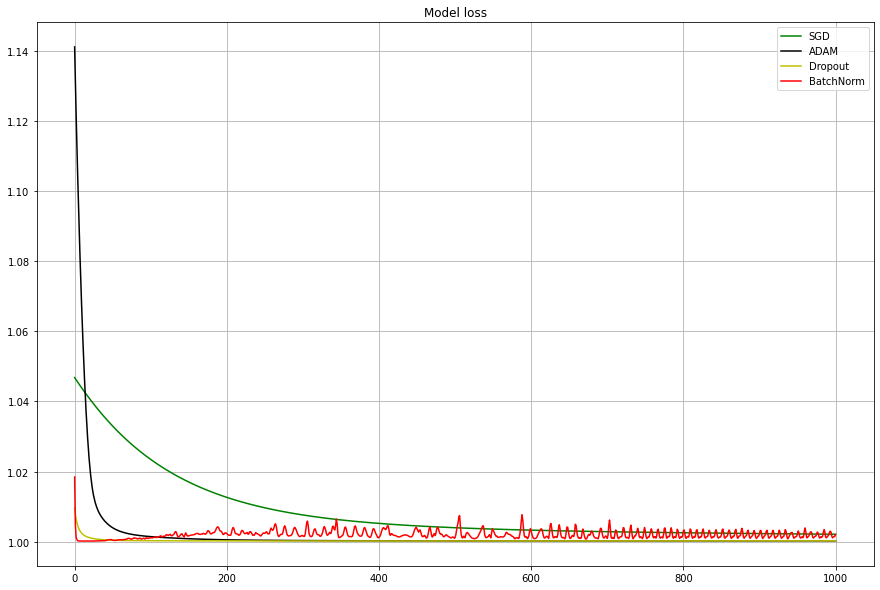

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(np.array(SGD), 'g', label ='SGD')
plt.plot(np.array(ADAM),'k', label ='ADAM')
plt.plot(np.array(Dropout),'y', label ='Dropout')
plt.plot(np.array(BatchNorm),'r', label ='BatchNorm')

plt.title('Model loss')
plt.legend(loc='upper right')
plt.legend()
plt.grid('on')
plt.show()

Case5_Bayes_Optimization

In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=8820eba654056b5653e9874c9076ec9492dba8b30ec9391d15335c0bcad04a94
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
#Pytorch library 불러오기
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
#데이터 불러오기

df = pd.read_csv('R5_test.csv')

# pandas data를 입력변수 X, 출력변수 y로 나누어줌
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3 , random_state=2)

# Train data
print("X_train size:" , X_train.shape)
print("y_train size:" , y_train.shape, '\n')

# Test data
print("X_test size:", X_test.shape)
print("y_test size:", y_test.shape)
print(type(y_train))

# training data Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train) #x_train scale is numpy ndarray

# test data Scaling
X_test_scale = scaler.transform(X_test) #x_test_scale is numpy ndarray

#-------numpy data --> Tensor ------------ tensor.detach().numpy()

# Array --> Tensor
X_train_tensor = torch.FloatTensor(X_train_scale)
y_train_tensor = torch.FloatTensor(y_train.values) #y_train is pandas series using vlues numpy ndarray

X_test_tensor = torch.FloatTensor(X_test_scale)
y_test_tensor = torch.FloatTensor(y_test.values)

#Training data batch learning
train_data = data_utils.TensorDataset(X_train_tensor, y_train_tensor)

dataloader = data_utils.DataLoader(train_data, batch_size = 100, shuffle = True, drop_last= True)

#Batch size check
for batch_idx, datas in enumerate(dataloader):
    print(batch_idx)
    print(datas[0].shape) #x_train
    print(datas[1].shape) #y_train
    break

#HyperParameter definition
input_dim = 4 #independent variable x
output_dim = 1 #output y
hidden_dim = 32 #(32,64,128,256)
hidden_1_dim = 16
learning_rate = 0.0001
n_epochs =1000
# hidden, epoch number reduction overfitting limitation.

#Modeling
class Batch_Norm(nn.Module):
    def __init__(self):
        super(Batch_Norm, self).__init__()
        
        self.network = nn.Sequential(nn.Linear(4, 32),
                                     nn.BatchNorm1d(32),
                                     nn.ReLU(),
                                     nn.Linear(32,16),
                                     nn.BatchNorm1d(16),
                                     nn.ReLU(),
                                     nn.Linear(16,1))

    def forward(self, x):
        output =self.network(x) #input network에 x 입력데이터를 넣는다

        return output

epoch = 15
learning_rate = 0.01
weight_decay = 1e-5

#model creation
model =Batch_Norm()
#loss function
criterion = torch.nn.MSELoss()
#Optimizer(ADAM_TRAINING_MANY OF TYPES)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

X_train size: (1041, 4)
y_train size: (1041,) 

X_test size: (447, 4)
y_test size: (447,)
<class 'pandas.core.series.Series'>
0
torch.Size([100, 4])
torch.Size([100])


In [ ]:
model

Batch_Norm(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [ ]:
#Training the model
def train_loss(lr, wd, ep, h_d, h_1_d): #() objective function hyperparameter

    train_loss = [] #empty list add
    test_loss =[]   #empty list add
    
    weight_decay = wd
    learning_rate = lr
    epoch = ep
    hidden_dim = h_d
    hidden_1_dim = h_1_d

    for epoch in range(n_epochs+1):

        #Batch learning
        for idx, (x_batch, y_batch) in enumerate(dataloader):
            #optimizer.zero_grad() #gradient value reset
            y_pred = model(x_batch)
            y_pred = y_pred.reshape(-1) #dimension reduction 100,1(y_pred) --> loss function same demension y_batch(100,) 
            loss_train = criterion(y_pred, y_batch) #same dimension
            loss_train.backward() #gradient value calcaulation
            #optimizer.step() #weight value update

            #Validation #train, test comparison
            y_test_pred = model(X_test_tensor)
            y_test_pred = y_test_pred.reshape(-1)
            loss_test = criterion(y_test_pred, y_test_tensor)
            loss_test = loss_test.detach()
            
 
        train_loss.append(loss_train.item())
        test_loss.append(loss_test.item())
            
    return -loss_test

In [ ]:
test_loss

[424738.875,
 422968.125,
 420532.5,
 417434.15625,
 413469.71875,
 407979.28125,
 400846.96875,
 391786.375,
 379630.3125,
 366221.8125,
 351344.40625,
 335146.65625,
 317879.125,
 299724.53125,
 281046.65625,
 262070.046875,
 243069.0625,
 223969.953125,
 205042.34375,
 186744.109375,
 168908.359375,
 152227.1875,
 136254.203125,
 121908.453125,
 107932.2265625,
 95826.84375,
 84469.734375,
 74807.3203125,
 65838.2421875,
 58592.09765625,
 51761.34375,
 46195.41015625,
 40688.8828125,
 36843.60546875,
 33169.1796875,
 30541.7265625,
 27880.1328125,
 26037.51171875,
 24116.189453125,
 23139.275390625,
 21906.38671875,
 21597.419921875,
 20763.4296875,
 20713.1171875,
 20110.51171875,
 19924.568359375,
 19809.125,
 19582.291015625,
 19313.744140625,
 19174.025390625,
 19112.28125,
 19064.50390625,
 19007.96875,
 19128.564453125,
 19169.134765625,
 19240.05859375,
 19215.775390625,
 19311.306640625,
 19401.05859375,
 19402.94140625,
 19414.013671875,
 19374.13671875,
 19411.251953125,
 

In [ ]:
pbounds = {'lr':(0,1),'wd':(0,1), 'ep':(1,100),'h_d':(32,256), 'h_1_d':(32,256)}   #하이퍼파라미터 범위 설정_딕셔너리 형태로
optimizer = BayesianOptimization( f=train_loss, pbounds = pbounds, random_state = 1)

optimizer.maximize(init_points =5, n_iter=10 ) #n_iter 초기 pointer를 제외하고 시행할 횟수, 
                                              #GP regression에서 처음에 학습할 데이터 수
                                              #n_iter 는 하이퍼파라미터를 찾아가는 횟수

|   iter    |  target   |    ep     |   h_1_d   |    h_d    |    lr     |    wd     |
-------------------------------------------------------------------------------------
|  1        | -4.258e+0 |  42.29    |  193.4    |  32.03    |  0.3023   |  0.1468   |
|  2        | -4.258e+0 |  10.14    |  73.72    |  109.4    |  0.3968   |  0.5388   |
|  3        | -4.258e+0 |  42.5     |  185.5    |  77.8     |  0.8781   |  0.02739  |
|  4        | -4.258e+0 |  67.38    |  125.5    |  157.1    |  0.1404   |  0.1981   |
|  5        | -4.258e+0 |  80.27    |  248.9    |  102.2    |  0.6923   |  0.8764   |
|  6        | -4.258e+0 |  7.998    |  251.7    |  251.6    |  0.5789   |  0.8279   |
|  7        | -4.258e+0 |  99.91    |  37.95    |  255.6    |  0.2798   |  0.2289   |
|  8        | -4.258e+0 |  10.36    |  35.93    |  37.65    |  0.3937   |  0.5744   |
|  9        | -4.258e+0 |  2.08     |  41.14    |  245.9    |  0.02007  |  0.9876   |
|  10       | -4.258e+0 |  99.38    |  35.9     |  34.

In [ ]:
#옵티마이저 최대값
print(optimizer.max)

#결과값으로 읽어줌
for i, res in enumerate(optimizer.res):
    print(f'Iteration{i}: \n\t{res}')

{'target': -425816.8125, 'params': {'ep': 42.28517846555483, 'h_1_d': 193.35268653104342, 'h_d': 32.025619959085255, 'lr': 0.30233257263183977, 'wd': 0.14675589081711304}}
Iteration0: 
	{'target': -425816.8125, 'params': {'ep': 42.28517846555483, 'h_1_d': 193.35268653104342, 'h_d': 32.025619959085255, 'lr': 0.30233257263183977, 'wd': 0.14675589081711304}}
Iteration1: 
	{'target': -425816.8125, 'params': {'ep': 10.141520882110981, 'h_1_d': 73.72228734859829, 'h_d': 109.40560285764269, 'lr': 0.39676747423066994, 'wd': 0.538816734003357}}
Iteration2: 
	{'target': -425816.8125, 'params': {'ep': 42.50025692592619, 'h_1_d': 185.48916808887412, 'h_d': 77.7973039398599, 'lr': 0.8781174363909454, 'wd': 0.027387593197926163}}
Iteration3: 
	{'target': -425816.8125, 'params': {'ep': 67.37628350766182, 'h_1_d': 125.47627573023644, 'h_d': 157.14652157184838, 'lr': 0.14038693859523377, 'wd': 0.1981014890848788}}
Iteration4: 
	{'target': -425816.8125, 'params': {'ep': 80.27371229887812, 'h_1_d': 248.8

In [ ]:
import pickle

# wb- 바이트 형식으로 저장

with open('BayesOpt.pickle', 'wb') as f:
     pickle.dump(test_loss, f)

In [ ]:
with open("BayesOpt.pickle", 'rb') as f: #각각 파일마다 피클로 저장해둬야 함
      BayesOpt = pickle.load(f)

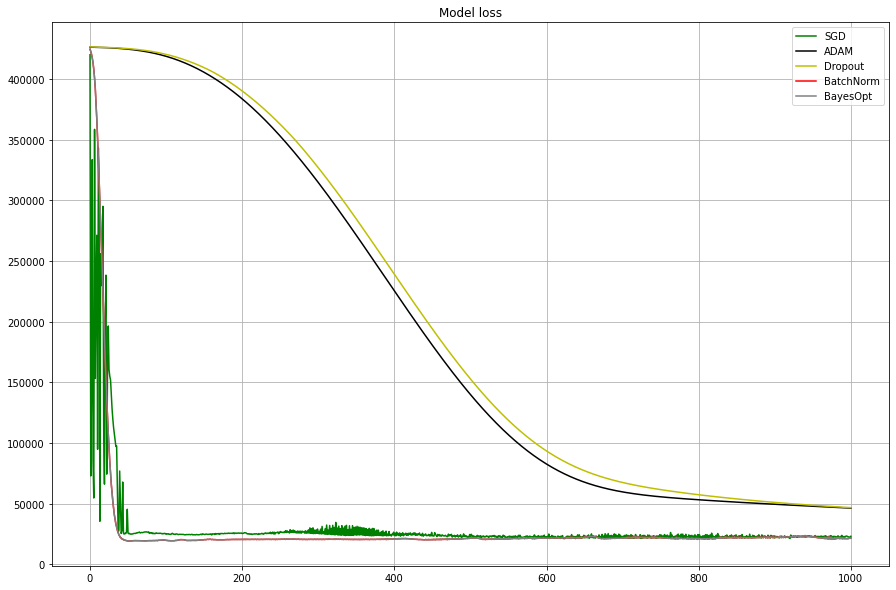

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(np.array(SGD), 'g', label ='SGD')
plt.plot(np.array(ADAM),'k', label ='ADAM')
plt.plot(np.array(Dropout),'y', label ='Dropout')
plt.plot(np.array(BatchNorm),'r', label ='BatchNorm')
plt.plot(np.array(BayesOpt), 'grey', label ='BayesOpt')

plt.title('Model loss')
plt.legend(loc='upper right')
plt.legend()
plt.grid('on')
plt.show()